This is a notebook created to work on the Stock Price Forecasting Project for Udacity Nano Degree Capstone project.
Key Steps to follow.
1. Downloading Data from Yahoo Finance
2. Data Preprocessing and Visulization
3. Upload Data to S3
4. Train Model
5. Model Evaluation
6. Benchmark Model Development
7. Benchmark Model Evaluation
8. Model Deployment
9. Create Web App

Step 0. Preparation Work

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
pip install pandas-datareader

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yfinance

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Step 1. Downloading Data from Yahoo Finance

In [4]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd
# Tickers list
# We can add and delete any ticker from the list to get desired ticker live data
ticker_list=['AXP']
today = date.today()
# We can get data by our choice by giving days bracket
start_date= "2016-01-01"
end_date="2020-02-15"
files=[]
def getData(ticker):
    print(ticker)
    data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
    dataname= ticker+'_'+str(today)
    files.append(dataname)
    SaveData(data, dataname)
# Create a data folder in your current dir.
def SaveData(df, filename):
    df.to_csv('./data/'+filename+'.csv')
#This loop will iterate over ticker list, will pass one ticker to get data, and save that data as file.
for tik in ticker_list:
    getData(tik)
for i in range(0,len(ticker_list)):
    df1= pd.read_csv('./data/'+ str(files[i])+'.csv')
print (df1.head(20))

AXP
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  \
0   2016-01-04  68.089996  68.180000  66.769997  67.589996  62.533890   
1   2016-01-05  67.370003  67.709999  65.669998  66.550003  61.571701   
2   2016-01-06  65.239998  65.550003  64.239998  64.419998  59.861889   
3   2016-01-07  63.310001  64.250000  63.080002  63.840000  59.322926   
4   2016-01-08  64.180000  64.410004  63.570000  63.630001  59.127777   
5   2016-01-11  63.740002  64.209999  63.099998  64.050003  59.518074   
6   2016-01-12  64.800003  64.900002  63.599998  64.400002  59.843296   
7   2016-01-13  63.650002  64.370003  62.230000  62.849998  58.402966   
8   2016-01-14  62.849998  63.750000  62.369999  63.290001  58.811840   
9   2016-01-15  62.029999  63.049999  61.500000  62.910000  58.458725   
10  2016-01-19  63.410000  63.790001  62.240002  62.639999  58.207825   
11  2016-01-20  61.540001  63.540001  61.290001  63

Step 2. Data Preprocessing and Visulization

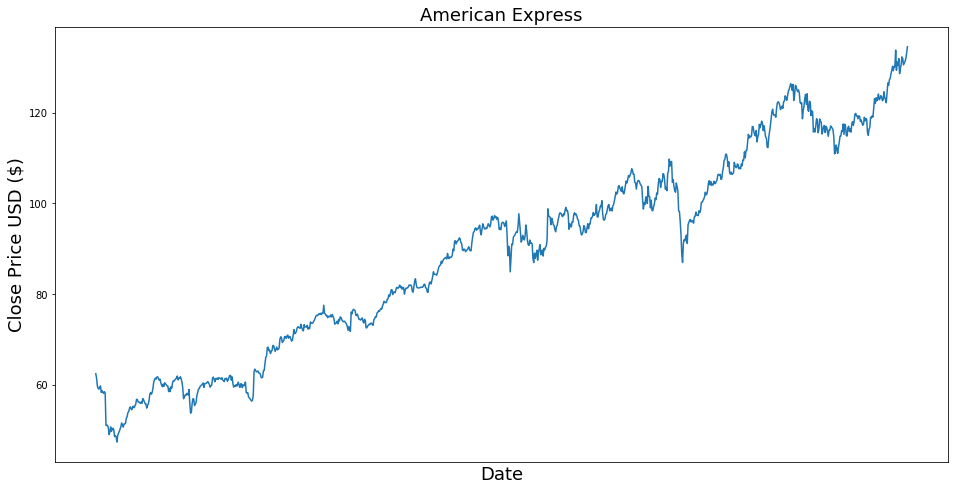

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)  
plt.plot(df1['Date'], df1['Adj Close'])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month

plt.title('American Express', fontsize = 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
price = df1[['Adj Close']]
print(df1.shape)
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Adj Close'] = scaler.fit_transform(price['Adj Close'].values.reshape(-1,1))
print(price.size)

(1037, 7)
1037


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
test_samp = 0.2
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(test_samp*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 30 # choose sequence length
train_X, train_y, test_X, test_y = split_data(price, lookback)
train_X = train_X.reshape(len(train_X),(lookback-1))
test_X = test_X.reshape(len(test_X),(lookback-1))

In [8]:
print(test_X)

[[0.43662854 0.39399395 0.41755529 ... 0.51786381 0.55659618 0.5376804 ]
 [0.39399395 0.41755529 0.36459829 ... 0.55659618 0.5376804  0.54826426]
 [0.41755529 0.36459829 0.35517372 ... 0.5376804  0.54826426 0.54353523]
 ...
 [0.72696447 0.73127299 0.77200286 ... 0.94038381 0.90784594 0.9174022 ]
 [0.73127299 0.77200286 0.74356009 ... 0.90784594 0.9174022  0.92627668]
 [0.77200286 0.74356009 0.73127299 ... 0.9174022  0.92627668 0.94015655]]


Step 3. Upload Data to S3

train_X = torch.from_numpy(train_X).type(torch.Tensor)
test_X = torch.from_numpy(test_X).type(torch.Tensor)
train_y = torch.from_numpy(train_y).type(torch.Tensor)
test_y = torch.from_numpy(test_y).type(torch.Tensor)


In [9]:
data_dir = './data'
filename = 'train.csv'
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis=1).dropna() \
        .to_csv(os.path.join(data_dir, filename), header=False, index=False)

In [10]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

role = sagemaker.get_execution_role()

In [11]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [18]:
from sagemaker.pytorch import PyTorch
role = sagemaker.get_execution_role()
estimator = PyTorch(entry_point="train.py",
                    source_dir="pytorch",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'input_dim' : 1,
                        'hidden_dim': 32,
                        'num_layers': 4,
                        'output_dim': 1,
                        'epochs' : 20
                    })

In [14]:
import torch
train_data = pd.read_csv(os.path.join(data_dir, "train.csv"), header=None, names=None)
train_y = torch.from_numpy(train_data[[0]].values).type(torch.Tensor)
train_x = train_data.drop([0], axis=1).to_numpy()
train_x = train_x.reshape(train_data.shape[0],1,-1)
print(train_x)
train_x = train_x.reshape(train_data.shape[0],-1,1)
print(train_x)

train_x = torch.from_numpy(train_x).type(torch.Tensor)
train_ds = torch.utils.data.TensorDataset(train_x, train_y)

[[[-0.65430889 -0.67642424 -0.71572328 ... -0.97479749 -1.
   -0.9668951 ]]

 [[-0.67642424 -0.71572328 -0.72811104 ... -1.         -0.9668951
   -0.95578894]]

 [[-0.71572328 -0.72811104 -0.73259641 ... -0.9668951  -0.95578894
   -0.94660461]]

 ...

 [[ 0.42944784  0.45570214  0.45637534 ...  0.43792233  0.4748529
    0.47597887]]

 [[ 0.45570214  0.45637534  0.43662854 ...  0.4748529   0.47597887
    0.51786381]]

 [[ 0.45637534  0.43662854  0.39399395 ...  0.47597887  0.51786381
    0.55659618]]]
[[[-0.65430889]
  [-0.67642424]
  [-0.71572328]
  ...
  [-0.97479749]
  [-1.        ]
  [-0.9668951 ]]

 [[-0.67642424]
  [-0.71572328]
  [-0.72811104]
  ...
  [-1.        ]
  [-0.9668951 ]
  [-0.95578894]]

 [[-0.71572328]
  [-0.72811104]
  [-0.73259641]
  ...
  [-0.9668951 ]
  [-0.95578894]
  [-0.94660461]]

 ...

 [[ 0.42944784]
  [ 0.45570214]
  [ 0.45637534]
  ...
  [ 0.43792233]
  [ 0.4748529 ]
  [ 0.47597887]]

 [[ 0.45570214]
  [ 0.45637534]
  [ 0.43662854]
  ...
  [ 0.4748529 ]
  

In [19]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-16 01:31:13 Starting - Starting the training job...
2020-08-16 01:31:15 Starting - Launching requested ML instances......
2020-08-16 01:32:28 Starting - Preparing the instances for training.........
2020-08-16 01:33:59 Downloading - Downloading input data
2020-08-16 01:33:59 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-16 01:34:22,448 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-16 01:34:22,450 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-16 01:34:22,465 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-16 01:34:22,468 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-16 01:34:22,700 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-08-16 01:34:22,


2020-08-16 01:34:46 Completed - Training job completed
Training seconds: 61
Billable seconds: 61


In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [ ]:
from sklearn import metrics
from math import sqrt
train_X2 = train_X.reshape(train_X.shape[0],-1,1).astype(np.float32)
test_X2 = test_X.reshape(test_X.shape[0],-1,1).astype(np.float32)
print(train_X2.shape)
print(test_X2.shape)
train_y_preds = predictor.predict(train_X2)
test_y_preds = predictor.predict(test_X2)

# Verify that model generates the correct number of predictions
assert len(train_y_preds)==len(train_y), 'Unexpected number of predictions.'
print('Test passed!')
assert len(test_y_preds)==len(test_y), 'Unexpected number of predictions.'
print('Test passed!')

# invert predictions
train_y_preds2 = scaler.inverse_transform(train_y_preds)
train_y2 = scaler.inverse_transform(train_y)
test_y_preds2 = scaler.inverse_transform(test_y_preds)
test_y2 = scaler.inverse_transform(test_y)

RMSE_train = sqrt(metrics.mean_squared_error(train_y,train_y_preds))
RMSE_test = sqrt(metrics.mean_squared_error(test_y,test_y_preds))

print('Train Score: %.2f RMSE' % (RMSE_train))
print('Test Score: %.2f RMSE' % (RMSE_test))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)  
plt.plot(train_y,label = 'Actual')
plt.plot(train_y_preds,label = 'Prediction')

plt.legend()
plt.title('American Express', fontsize = 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)  
plt.plot(test_y2,label = 'Actual')
plt.plot(test_y_preds2,label = 'Prediction')

plt.legend()
plt.title('American Express', fontsize = 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()